# Analysis of motif contributions

This notebook uses the motifs identified in `extract_filters_ensemble.ipynb` and calculates:

- Motif matches across all sequences in the MPRA using FIMO.
- For each match region, the contribution to each of the model outputs.
- The average motif contribution across all matches, and produces the heatmap in Figure 5.
- For each motif, their dependence of contribution on sequence length, motif position, GC content, and other features.
- For each motif, their dependence of contribution on secondary structure features.

In [1]:
import os
import pickle
import sys

import numpy
import pandas
import matplotlib
from matplotlib import pyplot
import seaborn
import scipy.stats

import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

utils_dir = '../utils'
sys.path.append(utils_dir)
import seq_utils
import custom_plots

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Arial'

# Load sequence, contribution, structure data

In [3]:
timepoint_list = [2, 4, 6, 10]

lib_tpm_col = 'TPM_library'
log2_lib_tpm_col = 'log2_TPM_library'

log2_mrl_cols = [f'log2_MRL_{t}hpf' for t in timepoint_list]
delta_log2_x_cols = [f'Δlog2_X_{t}hpf' for t in timepoint_list]

res_log2_mrl_cols = [f'res_log2_MRL_{t}hpf' for t in timepoint_list]
res_delta_log2_x_cols = [f'res_Δlog2_X_{t}hpf' for t in timepoint_list]

log2_x_cols = [f'log2_X_{t}hpf' for t in timepoint_list]

# Predictions
pred_len_cols = [f'pred_len_{c}' for c in log2_mrl_cols + delta_log2_x_cols]
pred_cnn_cols = [f'pred_cnn_ens_{c}' for c in log2_mrl_cols + delta_log2_x_cols]
pred_full_cols = [f'pred_full_{c}' for c in log2_mrl_cols + delta_log2_x_cols]

In [4]:
# Load data
data_full = pandas.read_csv(
    '../full_model_evaluation/Zb_5UTR_MPRA_with_preds.tsv',
    index_col=0,
    sep='\t',
)
data_full['insert_length'] = data_full['insert_length'].astype(int)

data_full

,chr,strand,external_gene_name,utr_length,insert_length,n_uORFs,GC_content,mxfold,index,index_base,...,pred_test_log2_MRL_10hpf,pred_full_log2_MRL_10hpf,pred_test_Δlog2_X_2hpf,pred_full_Δlog2_X_2hpf,pred_test_Δlog2_X_4hpf,pred_full_Δlog2_X_4hpf,pred_test_Δlog2_X_6hpf,pred_full_Δlog2_X_6hpf,pred_test_Δlog2_X_10hpf,pred_full_Δlog2_X_10hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,chr9,-,slc35a5,103.0,103,2.0,52.427184,23.9,20318.0,20318,...,2.390045,2.553573,-1.719531,-1.708624,-0.710143,-0.665578,-1.793335,-1.837050,-1.989746,-2.020408
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,chr4,-,nrf1,134.0,134,0.0,61.940299,35.3,72681.0,72681,...,2.448878,2.415843,-1.891235,-1.980832,-0.591849,-0.552270,-2.007738,-1.982406,-1.125323,-1.193949
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,chr4,+,ube2h,178.0,178,1.0,46.629213,30.1,27446.0,27446,...,2.501041,2.379249,-1.884392,-1.935805,-0.474855,-0.408718,-2.229212,-2.221917,-0.678730,-0.704322
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,chr12,+,slc9a3r1a,152.0,152,0.0,46.052632,26.1,113092.0,113092,...,2.627780,2.763784,-2.367868,-2.355859,-0.430069,-0.409165,-2.052849,-2.026948,-0.662411,-0.576333
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,chr24,-,dap,153.0,153,1.0,47.058824,31.8,20320.0,20320,...,2.482960,2.497563,-2.452622,-2.273506,-0.449078,-0.530098,-2.020428,-2.029758,-1.015012,-0.949125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000060397_ENSDART00000085051_231_hhip_26758.1,chr1,+,hhip,410.0,209,2.0,31.578947,26.3,26758.1,26758,...,1.053673,1.320685,-2.363133,-3.065505,-0.596964,-0.732703,-2.512594,-2.252490,-0.694722,-1.061540
ENSDARG00000098284_ENSDART00000170620_10459_ctxn1_29429.4,chr22,+,ctxn1,678.0,174,0.0,51.724138,41.2,29429.4,29429,...,2.446544,3.069664,-3.353687,-3.767259,-0.960340,-0.857212,-1.829986,-1.724766,-0.918232,-0.969787
ENSDARG00000103318_ENSDART00000161570_7325_mrpl3_86762,chr19,+,mrpl3,111.0,111,2.0,34.234234,12.5,86762.0,86762,...,3.249464,3.248826,-2.183509,-2.343830,-0.353026,-0.293256,-1.775180,-1.836341,-1.560418,-1.601856
ENSDARG00000036698_ENSDART00000053300_7697_znf865_21263.6,chr19,-,znf865,1305.0,197,4.0,31.979695,25.9,21263.6,21263,...,2.189054,2.129192,-3.107413,-3.142238,-0.903177,-0.738932,-1.897865,-1.976108,-1.214759,-0.988991


In [5]:
# Preserve only rows with input tpm above threshold
tpm_threshold = 3
data = data_full[data_full[lib_tpm_col] > tpm_threshold]
print(f"{len(data_full):,} total sequences, {len(data):,} retained.")

17,951 total sequences, 17,951 retained.


In [6]:
# Maximum sequence length
max_seq_len = int(data_full['insert_length'].max())
max_seq_len

238

In [7]:
# Load contribution scores
# Dictionary, where keys are insert ids and values are numpy arrays
# with dimensions (n_model_outputs, max_seq_len, 4)

with open('../contributions/contributions_ensemble_cnn_model.pickle', 'rb') as handle:
    contributions_dict = pickle.load(handle)
assert set(data.index.to_list()) == set(contributions_dict.keys())
print(f"Contribution scores for {len(contributions_dict):,} sequences loaded.")

Contribution scores for 17,951 sequences loaded.


In [8]:
# Load secondary structure results
# Dictionary, where keys are insert ids and values are dictionaries
with open('../secondary_structure/stucture_results_28C.pickle', 'rb') as handle:
    struct_info_dict = pickle.load(handle)
struct_dict = struct_info_dict['structure_results']
struct_dict[data.index[0]]

{'free_energy': -89.16079055134124,
 'mfe_structures_str': ['...........((((((.((.(.((((((........)))))).)))))))))(((((.(....).)))))...(((((((((((.((((((.((..((.....(((((((.((.......)).))).))))))..)).)))))).)))))))).))).....(((..((.((.(.(((((.(.(((...((....)).)))).)))))).)).))..)))....',
  '...........((((((.((.(.((((((........)))))).)))))))))(((((.(....).)))))...(((((((((((.((((((.((..((.....(((((((.((.......)).))).))))))..)).)))))).)))))))).))).....(((..((.((.((.((((.(.(((...((....)).)))).)))))).)).))..)))....',
  '...........((((((.((.(.((((((........)))))).)))))))))(((((.(....).)))))...(((((((((((.((((((.((..((.....(((((((.((.......)).)))).)))))..)).)))))).)))))))).))).....(((..((.((.(.(((((.(.(((...((....)).)))).)))))).)).))..)))....',
  '...........((((((.((.(.((((((........)))))).)))))))))(((((.(....).)))))...(((((((((((.((((((.((..((.....(((((((.((.......)).)))).)))))..)).)))))).)))))))).))).....(((..((.((.((.((((.(.(((...((....)).)))).)))))).)).))..)))....'],
 'mfe_energy': [-

# Load motif data

In [9]:
motif_base_dir = 'results/last_layer_2_n_100'

In [10]:
# Load motif pwms
motifs_dict = seq_utils.load_meme(
    os.path.join(motif_base_dir, 'motifs.meme')
)
motifs_dict

{'aug_cluster_1': {'name': 'aug_cluster_1',
  'ppm': array([[0.276449, 0.355093, 0.201041, 0.167417],
         [0.59868 , 0.072486, 0.270619, 0.058215],
         [0.333018, 0.206939, 0.101962, 0.35808 ],
         [0.238267, 0.22479 , 0.408973, 0.12797 ],
         [0.935453, 0.022816, 0.029613, 0.012117],
         [0.01058 , 0.014304, 0.01655 , 0.958565],
         [0.006857, 0.009162, 0.974997, 0.008985],
         [0.206407, 0.120641, 0.434921, 0.238031]]),
  'url': None,
  'nsites': 16900},
 'aug_cluster_3': {'name': 'aug_cluster_3',
  'ppm': array([[0.348261, 0.121304, 0.158696, 0.371739],
         [0.297391, 0.026087, 0.65    , 0.026522],
         [0.335652, 0.316957, 0.164348, 0.183043],
         [0.545217, 0.263913, 0.125217, 0.065652],
         [0.958696, 0.004348, 0.023478, 0.013478],
         [0.018696, 0.022609, 0.015652, 0.943043],
         [0.004348, 0.012609, 0.97087 , 0.012174],
         [0.299565, 0.15913 , 0.151304, 0.39    ]]),
  'url': None,
  'nsites': 2300},
 'aug_clu

In [11]:
motifs_df = pandas.read_csv(os.path.join(motif_base_dir, 'motifs.csv'), index_col=0)
motifs_df

,id,name,n_filters,n_models
aug_cluster_1,"motifs_aug_model_9_filter_110_n224,motifs_aug_...","model_9_filter_110,model_9_filter_008,model_5_...",169.0,10.0
aug_cluster_3,"motifs_aug_model_6_filter_080_n153,motifs_aug_...","model_6_filter_080,model_4_filter_103,model_8_...",23.0,10.0
aug_cluster_2,"motifs_aug_model_3_filter_093_n89,motifs_aug_m...","model_3_filter_093,model_1_filter_068,model_2_...",28.0,9.0
nonaug_cluster_007,"motifs_nonaug_model_0_filter_091_n73,motifs_no...","model_0_filter_091,model_2_filter_031,model_0_...",22.0,10.0
nonaug_cluster_011,"motifs_nonaug_model_3_filter_083_n381,motifs_n...","model_3_filter_083,model_8_filter_086,model_3_...",24.0,9.0
nonaug_cluster_044,"motifs_nonaug_model_1_filter_016_n115,motifs_n...","model_1_filter_016,model_6_filter_097,model_2_...",19.0,8.0
nonaug_cluster_108,"motifs_nonaug_model_2_filter_013_n222,motifs_n...","model_2_filter_013,model_8_filter_033,model_3_...",9.0,7.0
nonaug_cluster_024,"motifs_nonaug_model_5_filter_057_n564,motifs_n...","model_5_filter_057,model_6_filter_109,model_7_...",9.0,6.0
nonaug_cluster_012,"motifs_nonaug_model_3_filter_082_n380,motifs_n...","model_3_filter_082,model_8_filter_119,model_1_...",5.0,5.0
nonaug_cluster_018,"motifs_nonaug_model_3_filter_114_n407,motifs_n...","model_3_filter_114,model_5_filter_070,model_9_...",5.0,5.0


# Perform motif scan

In [12]:
# Export all MPRA sequences to fasta to use with FIMO
seq_records = []

# Iterate over DataFrame rows and create SeqRecord objects
# id can't be too long so we're using the position within the data table
for insert_idx, (index, row) in enumerate(data.iterrows()):
    sequence = row['insert_seq']
    record = SeqRecord(Seq(sequence), id=str(insert_idx), description='')
    seq_records.append(record)

# Specify the output file name
output_file = '5utr_sequences.fasta'

# Write SeqRecord objects to the output file in FASTA format
with open(output_file, 'w') as f:
    SeqIO.write(seq_records, f, 'fasta')

In [13]:
# Run FIMO with the following command
print(f"fimo --text --norc {motif_base_dir}/motifs.meme 5utr_sequences.fasta > {motif_base_dir}/motif_scan.tsv")

fimo --text --norc results/last_layer_2_n_100/motifs.meme 5utr_sequences.fasta > results/last_layer_2_n_100/motif_scan.tsv


In [12]:
# Reload, fix the sequence name issue, and save
motif_scan_df = pandas.read_csv(
    os.path.join(motif_base_dir, 'motif_scan.tsv'),
    sep='\t',
)
# Recover original sequence name
motif_scan_df['sequence_name'] = data.iloc[motif_scan_df['sequence_name']].index.values
# Save back
motif_scan_df.to_csv(
    os.path.join(motif_base_dir, 'motif_scan.tsv'),
    sep='\t',
    index=False,
)

ValueError: invalid literal for int() with base 10: 'ENSDARG00000000086_ENSDART00000132378_720_itsn1_121559'

# Load and process motif scan results

In [12]:
# Load motif scan results
motif_scan_df = pandas.read_csv(
    os.path.join(motif_base_dir, 'motif_scan.tsv'),
    sep='\t',
)

motif_scan_df

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,aug_cluster_1,aug_cluster_1,ENSDARG00000000086_ENSDART00000132378_720_itsn...,154,161,+,8.8080,0.000076,NaN,CATAATGG
1,aug_cluster_1,aug_cluster_1,ENSDARG00000000567_ENSDART00000155518_13808_zn...,20,27,+,9.4880,0.000030,NaN,CAAGATGG
2,aug_cluster_1,aug_cluster_1,ENSDARG00000002830_ENSDART00000046384_15406_tr...,4,11,+,9.1280,0.000061,NaN,AAAGATGG
3,aug_cluster_1,aug_cluster_1,ENSDARG00000006253_ENSDART00000126236_1249_mie...,64,71,+,9.4880,0.000030,NaN,CAAGATGG
4,aug_cluster_1,aug_cluster_1,ENSDARG00000007477_ENSDART00000015323_650_fbxo...,113,120,+,8.8000,0.000092,NaN,CACGATGG
...,...,...,...,...,...,...,...,...,...,...
16288,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000009958_ENSDART00000006085_4482_cbl...,4,14,+,10.7297,0.000078,NaN,GATAGAGAAAG
16289,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000068894_ENSDART00000149580_1475_nri...,76,86,+,10.5856,0.000088,NaN,GACAGAGAAAC
16290,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000004877_ENSDART00000166573_9505_roc...,74,84,+,10.6937,0.000082,NaN,GGGGGAGACAG
16291,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000005458_ENSDART00000056921_8172_csn...,25,35,+,11.9640,0.000027,NaN,GAGGGAGAAAA


In [13]:
# Add some sequence features from data table
motif_scan_df = motif_scan_df.merge(
    data[['insert_length', 'n_uORFs', 'GC_content', 'mxfold']],
    left_on='sequence_name',
    right_index=True,
)
motif_scan_df

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,insert_length,n_uORFs,GC_content,mxfold
0,aug_cluster_1,aug_cluster_1,ENSDARG00000000086_ENSDART00000132378_720_itsn...,154,161,+,8.8080,0.000076,NaN,CATAATGG,212,3.0,52.830189,39.6
1,aug_cluster_1,aug_cluster_1,ENSDARG00000000567_ENSDART00000155518_13808_zn...,20,27,+,9.4880,0.000030,NaN,CAAGATGG,229,2.0,53.275109,57.0
10277,nonaug_cluster_024,nonaug_cluster_024,ENSDARG00000000567_ENSDART00000155518_13808_zn...,167,177,+,12.8515,0.000007,NaN,CCATCTCCCCC,229,2.0,53.275109,57.0
2,aug_cluster_1,aug_cluster_1,ENSDARG00000002830_ENSDART00000046384_15406_tr...,4,11,+,9.1280,0.000061,NaN,AAAGATGG,114,2.0,37.719298,18.7
3,aug_cluster_1,aug_cluster_1,ENSDARG00000006253_ENSDART00000126236_1249_mie...,64,71,+,9.4880,0.000030,NaN,CAAGATGG,148,0.0,53.378378,39.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16288,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000009958_ENSDART00000006085_4482_cbl...,4,14,+,10.7297,0.000078,NaN,GATAGAGAAAG,173,1.0,49.132948,31.5
16289,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000068894_ENSDART00000149580_1475_nri...,76,86,+,10.5856,0.000088,NaN,GACAGAGAAAC,163,1.0,45.398773,25.6
16290,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000004877_ENSDART00000166573_9505_roc...,74,84,+,10.6937,0.000082,NaN,GGGGGAGACAG,186,1.0,45.161290,40.5
16291,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000005458_ENSDART00000056921_8172_csn...,25,35,+,11.9640,0.000027,NaN,GAGGGAGAAAA,197,3.0,43.654822,31.8


In [14]:
# Add secondary structure metrics
ss_prefix_len = len(struct_info_dict['seq_prefix'])
ss_suffix_len = len(struct_info_dict['seq_suffix'])
for index, row in motif_scan_df.iterrows():
    seq_id = row['sequence_name']
    seq_struct_dict = struct_dict[seq_id]

    motif_scan_df.at[index, 'free_energy'] = seq_struct_dict['free_energy']

    start_pos = row['start'] - 1
    end_pos = row['stop']
    assert(len(seq_struct_dict['unpaired_prob']) - ss_prefix_len - ss_suffix_len == data.loc[seq_id, 'insert_length'])
    match_unpaired_prob = seq_struct_dict['unpaired_prob'][ss_prefix_len + start_pos:ss_prefix_len + end_pos]
    motif_scan_df.at[index, 'mean_unpaired_prob'] = numpy.mean(match_unpaired_prob)

motif_scan_df

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,insert_length,n_uORFs,GC_content,mxfold,free_energy,mean_unpaired_prob
0,aug_cluster_1,aug_cluster_1,ENSDARG00000000086_ENSDART00000132378_720_itsn...,154,161,+,8.8080,0.000076,NaN,CATAATGG,212,3.0,52.830189,39.6,-115.974165,0.777276
1,aug_cluster_1,aug_cluster_1,ENSDARG00000000567_ENSDART00000155518_13808_zn...,20,27,+,9.4880,0.000030,NaN,CAAGATGG,229,2.0,53.275109,57.0,-134.012291,0.463546
10277,nonaug_cluster_024,nonaug_cluster_024,ENSDARG00000000567_ENSDART00000155518_13808_zn...,167,177,+,12.8515,0.000007,NaN,CCATCTCCCCC,229,2.0,53.275109,57.0,-134.012291,0.244787
2,aug_cluster_1,aug_cluster_1,ENSDARG00000002830_ENSDART00000046384_15406_tr...,4,11,+,9.1280,0.000061,NaN,AAAGATGG,114,2.0,37.719298,18.7,-75.376435,0.635903
3,aug_cluster_1,aug_cluster_1,ENSDARG00000006253_ENSDART00000126236_1249_mie...,64,71,+,9.4880,0.000030,NaN,CAAGATGG,148,0.0,53.378378,39.9,-96.001943,0.312708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16288,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000009958_ENSDART00000006085_4482_cbl...,4,14,+,10.7297,0.000078,NaN,GATAGAGAAAG,173,1.0,49.132948,31.5,-98.193617,0.988464
16289,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000068894_ENSDART00000149580_1475_nri...,76,86,+,10.5856,0.000088,NaN,GACAGAGAAAC,163,1.0,45.398773,25.6,-98.329289,0.499209
16290,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000004877_ENSDART00000166573_9505_roc...,74,84,+,10.6937,0.000082,NaN,GGGGGAGACAG,186,1.0,45.161290,40.5,-106.911768,0.574635
16291,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000005458_ENSDART00000056921_8172_csn...,25,35,+,11.9640,0.000027,NaN,GAGGGAGAAAA,197,3.0,43.654822,31.8,-98.787885,0.781355


In [15]:
# Add derived metrics
motif_scan_df['-log10(pvalue)'] = -numpy.log10(motif_scan_df['p-value'])
motif_scan_df['pos_from_5end'] = (motif_scan_df['start'] - 1 + motif_scan_df['stop'] - 1) / 2
motif_scan_df['pos_from_aug'] = motif_scan_df['pos_from_5end'] - motif_scan_df['insert_length']
motif_scan_df['relative_pos'] = motif_scan_df['pos_from_5end'] / motif_scan_df['insert_length']
motif_scan_df['adj_free_energy'] = motif_scan_df['free_energy'] / (motif_scan_df['insert_length'] + ss_prefix_len + ss_suffix_len)

In [16]:
# Add contributions to motif scan results
contrib_cols = [f'contrib_{c}' for c in log2_mrl_cols + delta_log2_x_cols]
motif_scan_df[contrib_cols] = numpy.nan

for index, motif_alignment in motif_scan_df.iterrows():
    seq_id = motif_alignment['sequence_name']
    seq = data.loc[seq_id, 'insert_seq']
    start_pos = motif_alignment['start'] - 1
    end_pos = motif_alignment['stop']
    assert(motif_alignment['matched_sequence']==seq[start_pos:end_pos])

    # Get contributions across the motif match region
    seq_onehot = seq_utils.one_hot_encode(
        [seq],
        max_seq_len=max_seq_len, padding='right', mask_val=0,
    )

    contributions_seq = contributions_dict[seq_id]
    projected_exp = numpy.array([
        numpy.sum(contributions_seq[model_output_idx][None,:,:]*seq_onehot, axis=-1)[0]
        for model_output_idx in range(len(log2_mrl_cols + delta_log2_x_cols))
    ])
    
    coord_offset = max_seq_len - len(seq)
    match_score = numpy.sum(projected_exp[:, start_pos + coord_offset: end_pos + coord_offset], axis=1)

    motif_scan_df.loc[index, contrib_cols] = match_score

motif_scan_df

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,...,relative_pos,adj_free_energy,contrib_log2_MRL_2hpf,contrib_log2_MRL_4hpf,contrib_log2_MRL_6hpf,contrib_log2_MRL_10hpf,contrib_Δlog2_X_2hpf,contrib_Δlog2_X_4hpf,contrib_Δlog2_X_6hpf,contrib_Δlog2_X_10hpf
0,aug_cluster_1,aug_cluster_1,ENSDARG00000000086_ENSDART00000132378_720_itsn...,154,161,+,8.8080,0.000076,NaN,CATAATGG,...,0.738208,-0.347228,-0.126682,-0.112978,-0.117262,-0.067681,-0.014263,-0.006694,-0.034366,-0.014953
1,aug_cluster_1,aug_cluster_1,ENSDARG00000000567_ENSDART00000155518_13808_zn...,20,27,+,9.4880,0.000030,NaN,CAAGATGG,...,0.098253,-0.381801,-0.218656,-0.160470,-0.115429,-0.032951,0.138950,0.001532,-0.046285,0.049974
10277,nonaug_cluster_024,nonaug_cluster_024,ENSDARG00000000567_ENSDART00000155518_13808_zn...,167,177,+,12.8515,0.000007,NaN,CCATCTCCCCC,...,0.746725,-0.381801,-0.052151,-0.052437,-0.030043,0.025506,-0.053519,-0.032457,0.017575,0.016302
2,aug_cluster_1,aug_cluster_1,ENSDARG00000002830_ENSDART00000046384_15406_tr...,4,11,+,9.1280,0.000061,NaN,AAAGATGG,...,0.057018,-0.319392,-0.221967,-0.177727,-0.165119,-0.232692,-0.003953,-0.016023,-0.079943,-0.143215
3,aug_cluster_1,aug_cluster_1,ENSDARG00000006253_ENSDART00000126236_1249_mie...,64,71,+,9.4880,0.000030,NaN,CAAGATGG,...,0.449324,-0.355563,-0.422223,-0.283723,-0.237040,-0.229601,0.155859,-0.045293,-0.028243,-0.053355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16288,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000009958_ENSDART00000006085_4482_cbl...,4,14,+,10.7297,0.000078,NaN,GATAGAGAAAG,...,0.046243,-0.332860,0.164567,0.099047,0.084068,0.028402,0.052609,0.012625,-0.064946,0.044084
16289,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000068894_ENSDART00000149580_1475_nri...,76,86,+,10.5856,0.000088,NaN,GACAGAGAAAC,...,0.490798,-0.345015,0.062664,0.048612,0.040775,0.038021,0.014084,0.007239,-0.005392,-0.000899
16290,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000004877_ENSDART00000166573_9505_roc...,74,84,+,10.6937,0.000082,NaN,GGGGGAGACAG,...,0.419355,-0.347116,0.022468,0.050918,0.044279,0.076447,0.111735,-0.031977,-0.009139,-0.002546
16291,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000005458_ENSDART00000056921_8172_csn...,25,35,+,11.9640,0.000027,NaN,GAGGGAGAAAA,...,0.147208,-0.309680,-0.061980,-0.008388,0.045244,0.068506,0.136634,-0.022180,-0.056749,0.009018


# Make plots

In [44]:
plot_ext = 'svg'

In [45]:
# Filter out motif matches that are too close to the sequence end
motif_scan_filtered_df = motif_scan_df[
    motif_scan_df['insert_length'] - motif_scan_df['stop'] > 4
]
motif_scan_filtered_df

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,...,relative_pos,adj_free_energy,contrib_log2_MRL_2hpf,contrib_log2_MRL_4hpf,contrib_log2_MRL_6hpf,contrib_log2_MRL_10hpf,contrib_Δlog2_X_2hpf,contrib_Δlog2_X_4hpf,contrib_Δlog2_X_6hpf,contrib_Δlog2_X_10hpf
0,aug_cluster_1,aug_cluster_1,ENSDARG00000000086_ENSDART00000132378_720_itsn...,154,161,+,8.8080,0.000076,NaN,CATAATGG,...,0.738208,-0.347228,-0.126682,-0.112978,-0.117262,-0.067681,-0.014263,-0.006694,-0.034366,-0.014953
1,aug_cluster_1,aug_cluster_1,ENSDARG00000000567_ENSDART00000155518_13808_zn...,20,27,+,9.4880,0.000030,NaN,CAAGATGG,...,0.098253,-0.381801,-0.218656,-0.160470,-0.115429,-0.032951,0.138950,0.001532,-0.046285,0.049974
10277,nonaug_cluster_024,nonaug_cluster_024,ENSDARG00000000567_ENSDART00000155518_13808_zn...,167,177,+,12.8515,0.000007,NaN,CCATCTCCCCC,...,0.746725,-0.381801,-0.052151,-0.052437,-0.030043,0.025506,-0.053519,-0.032457,0.017575,0.016302
2,aug_cluster_1,aug_cluster_1,ENSDARG00000002830_ENSDART00000046384_15406_tr...,4,11,+,9.1280,0.000061,NaN,AAAGATGG,...,0.057018,-0.319392,-0.221967,-0.177727,-0.165119,-0.232692,-0.003953,-0.016023,-0.079943,-0.143215
3,aug_cluster_1,aug_cluster_1,ENSDARG00000006253_ENSDART00000126236_1249_mie...,64,71,+,9.4880,0.000030,NaN,CAAGATGG,...,0.449324,-0.355563,-0.422223,-0.283723,-0.237040,-0.229601,0.155859,-0.045293,-0.028243,-0.053355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16288,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000009958_ENSDART00000006085_4482_cbl...,4,14,+,10.7297,0.000078,NaN,GATAGAGAAAG,...,0.046243,-0.332860,0.164567,0.099047,0.084068,0.028402,0.052609,0.012625,-0.064946,0.044084
16289,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000068894_ENSDART00000149580_1475_nri...,76,86,+,10.5856,0.000088,NaN,GACAGAGAAAC,...,0.490798,-0.345015,0.062664,0.048612,0.040775,0.038021,0.014084,0.007239,-0.005392,-0.000899
16290,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000004877_ENSDART00000166573_9505_roc...,74,84,+,10.6937,0.000082,NaN,GGGGGAGACAG,...,0.419355,-0.347116,0.022468,0.050918,0.044279,0.076447,0.111735,-0.031977,-0.009139,-0.002546
16291,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000005458_ENSDART00000056921_8172_csn...,25,35,+,11.9640,0.000027,NaN,GAGGGAGAAAA,...,0.147208,-0.309680,-0.061980,-0.008388,0.045244,0.068506,0.136634,-0.022180,-0.056749,0.009018


## Contribution per motif

In [46]:
# Folder for these plots
plot_dir = os.path.join(motif_base_dir, 'plots_motif_contrib')
os.makedirs(plot_dir, exist_ok=True)

In [47]:
# Code to extent outputs to include MRL differences with respect to the initial timepoint
def make_extended_output(val):
    val_extended = numpy.array([
            val[:, 0],
            val[:, 1],
            val[:, 2],
            val[:, 3],
            val[:, 3] - val[:, 0],
            val[:, 4],
            val[:, 5],
            val[:, 6],
            val[:, 7],
        ]).T
    return val_extended

model_outputs_ext_labels = [
    'log2_MRL_2hpf',
    'log2_MRL_4hpf',
    'log2_MRL_6hpf',
    'log2_MRL_10hpf',

    'Δlog2_MRL_10-2hpf',

    'Δlog2_X_2hpf',
    'Δlog2_X_4hpf',
    'Δlog2_X_6hpf',
    'Δlog2_X_10hpf',
]
contrib_ext_cols = [f'contrib_{c}' for c in model_outputs_ext_labels]

In [48]:
# Add extended columns
motif_scan_filtered_df[contrib_ext_cols] = pandas.DataFrame(
    make_extended_output(motif_scan_filtered_df[contrib_cols].values),
    index=motif_scan_filtered_df.index,
    columns=contrib_ext_cols,
)
motif_scan_filtered_df

C:\Users\casti\AppData\Local\Temp\ipykernel_29468\3594686571.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  motif_scan_filtered_df[contrib_ext_cols] = pandas.DataFrame(
C:\Users\casti\AppData\Local\Temp\ipykernel_29468\3594686571.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  motif_scan_filtered_df[contrib_ext_cols] = pandas.DataFrame(


,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,...,adj_free_energy,contrib_log2_MRL_2hpf,contrib_log2_MRL_4hpf,contrib_log2_MRL_6hpf,contrib_log2_MRL_10hpf,contrib_Δlog2_X_2hpf,contrib_Δlog2_X_4hpf,contrib_Δlog2_X_6hpf,contrib_Δlog2_X_10hpf,contrib_Δlog2_MRL_10-2hpf
0,aug_cluster_1,aug_cluster_1,ENSDARG00000000086_ENSDART00000132378_720_itsn...,154,161,+,8.8080,0.000076,NaN,CATAATGG,...,-0.347228,-0.126682,-0.112978,-0.117262,-0.067681,-0.014263,-0.006694,-0.034366,-0.014953,0.059002
1,aug_cluster_1,aug_cluster_1,ENSDARG00000000567_ENSDART00000155518_13808_zn...,20,27,+,9.4880,0.000030,NaN,CAAGATGG,...,-0.381801,-0.218656,-0.160470,-0.115429,-0.032951,0.138950,0.001532,-0.046285,0.049974,0.185704
10277,nonaug_cluster_024,nonaug_cluster_024,ENSDARG00000000567_ENSDART00000155518_13808_zn...,167,177,+,12.8515,0.000007,NaN,CCATCTCCCCC,...,-0.381801,-0.052151,-0.052437,-0.030043,0.025506,-0.053519,-0.032457,0.017575,0.016302,0.077657
2,aug_cluster_1,aug_cluster_1,ENSDARG00000002830_ENSDART00000046384_15406_tr...,4,11,+,9.1280,0.000061,NaN,AAAGATGG,...,-0.319392,-0.221967,-0.177727,-0.165119,-0.232692,-0.003953,-0.016023,-0.079943,-0.143215,-0.010725
3,aug_cluster_1,aug_cluster_1,ENSDARG00000006253_ENSDART00000126236_1249_mie...,64,71,+,9.4880,0.000030,NaN,CAAGATGG,...,-0.355563,-0.422223,-0.283723,-0.237040,-0.229601,0.155859,-0.045293,-0.028243,-0.053355,0.192623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16288,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000009958_ENSDART00000006085_4482_cbl...,4,14,+,10.7297,0.000078,NaN,GATAGAGAAAG,...,-0.332860,0.164567,0.099047,0.084068,0.028402,0.052609,0.012625,-0.064946,0.044084,-0.136165
16289,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000068894_ENSDART00000149580_1475_nri...,76,86,+,10.5856,0.000088,NaN,GACAGAGAAAC,...,-0.345015,0.062664,0.048612,0.040775,0.038021,0.014084,0.007239,-0.005392,-0.000899,-0.024643
16290,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000004877_ENSDART00000166573_9505_roc...,74,84,+,10.6937,0.000082,NaN,GGGGGAGACAG,...,-0.347116,0.022468,0.050918,0.044279,0.076447,0.111735,-0.031977,-0.009139,-0.002546,0.053979
16291,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000005458_ENSDART00000056921_8172_csn...,25,35,+,11.9640,0.000027,NaN,GAGGGAGAAAA,...,-0.309680,-0.061980,-0.008388,0.045244,0.068506,0.136634,-0.022180,-0.056749,0.009018,0.130486


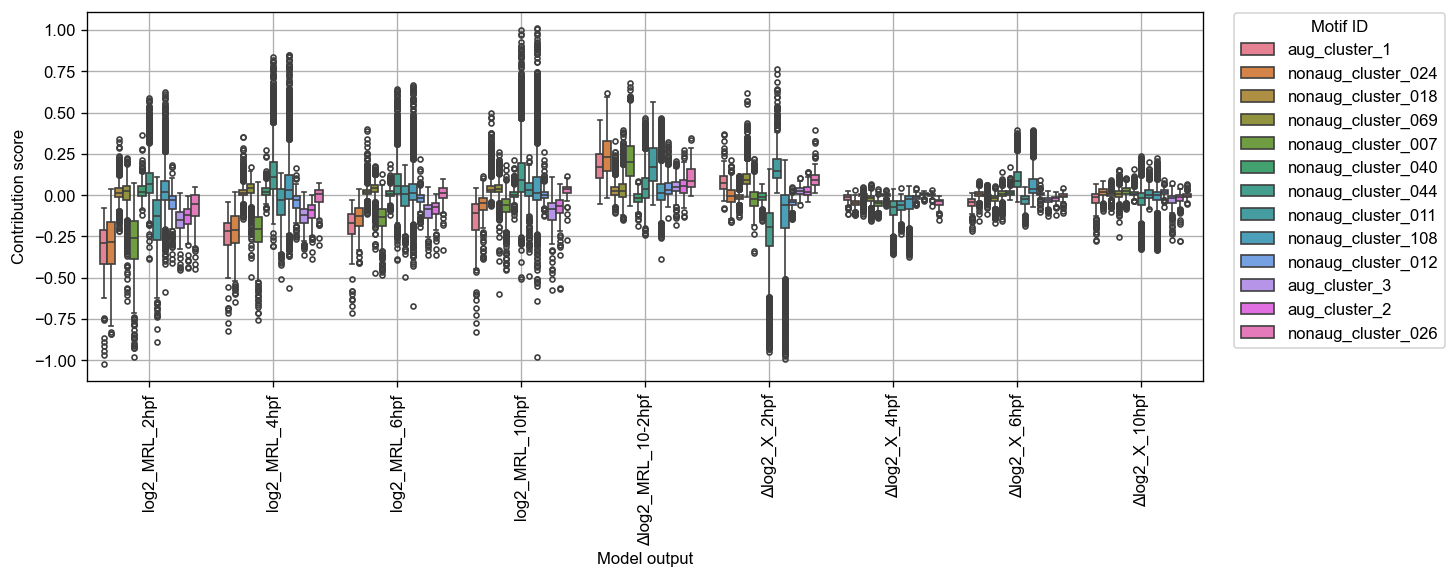

In [49]:
# Box plot of contributions. One box for each model output
data_to_plot = motif_scan_filtered_df[['motif_id'] + contrib_ext_cols]
data_to_plot = pandas.melt(data_to_plot, id_vars='motif_id', value_vars=contrib_ext_cols)
data_to_plot['variable'] = data_to_plot['variable'].str.replace('contrib_', '')
data_to_plot = data_to_plot.rename(columns={'variable': 'model_output', 'value': 'contribution'})

fig, ax = pyplot.subplots(figsize=(12, 4))
seaborn.boxplot(
    x='model_output',
    y='contribution',
    hue='motif_id',
    data=data_to_plot,
    fliersize=3,
    ax=ax,
)
ax.set_ylabel('Contribution score')
ax.set_xlabel('Model output')
ax.grid(True)
ax.tick_params(axis='x', labelrotation=90)
ax.legend(title='Motif ID', bbox_to_anchor=(1.02, 1.02), loc='upper left')
fig.savefig(os.path.join(plot_dir, f'motif_contrib_boxplot.{plot_ext}'), bbox_inches='tight')

In [50]:
def plot_motif_contrib_heatmap(
        df_to_plot,
        cbar_label,
        cols_labels=None,
        savefig=None,
        bg_color=None,
        **heatmap_kwargs,
    ):
    # Get max motif length for plotting
    max_pwm_len = 0
    for motif_id, motifs_info in motifs_dict.items():
        max_pwm_len = max(max_pwm_len, len(motifs_info['ppm']))

    # Initialize plot
    gs_kw = dict(width_ratios=[0.45, 1], height_ratios=[1]*df_to_plot.shape[0])
    fig, axd = pyplot.subplot_mosaic(
        [[cluster_id, 'heatmap'] for cluster_id, row in df_to_plot.iterrows()],
        gridspec_kw=gs_kw,
        num=1,
        clear=True,
    )
    fig.set_size_inches(df_to_plot.shape[1]*0.35, df_to_plot.shape[0]*0.2)
    fig.subplots_adjust(wspace=0.05)

    # Plot heatmap with contributions
    ax = axd['heatmap']
    seaborn.heatmap(
        df_to_plot,
        yticklabels=False,
        xticklabels=True,
        cbar_kws={'fraction': 0.05, 'label': cbar_label},
        ax=ax,
        **heatmap_kwargs,
    )
    if bg_color is not None:
        ax.set_facecolor(bg_color)
    if cols_labels is not None:
        ax.set_xticklabels(cols_labels, rotation=90, ha='right')
    ax.set_ylabel('')

    # Plot motif cluster logos
    for cluster_id, row in df_to_plot.iterrows():
        ax = axd[cluster_id]
        ax.set_xticks([])
        ax.set_yticks([])

        cluster_pwm = motifs_dict[cluster_id]['ppm']
        custom_plots.plot_seq_logo(seq_val=cluster_pwm, ax=ax, spines=False)
        ax.spines.bottom.set_visible(False)
        ax.set_ylim(0, 2)
        # Adjust xlim based on pwm length
        xlim = ax.get_xlim()
        ax.set_xlim(xlim[0] - max_pwm_len + len(cluster_pwm), xlim[1])
        cluster_id_short = cluster_id.rsplit('_', 1)
        cluster_id_short = f"{cluster_id_short[0][0]}{int(cluster_id_short[1]):03d}"
        ax.set_ylabel(cluster_id_short, rotation=0, va='center', ha='right')

    if savefig is not None:
        fig.savefig(savefig, dpi=200, bbox_inches='tight')
        pyplot.close(fig)
    else:
        return fig


In [51]:
def plot_scatter_feature_vs_contrib(
        df_to_plot,
        feature_col,
        stat_to_annotate='r',
        motifs_to_plot=None,
        savefig=None,
    ):
    if motifs_to_plot is None:
        motifs_to_plot = df_to_plot['motif_id'].unique()

    rvalue_df = pandas.DataFrame(
        index=motifs_to_plot,
        columns=model_outputs_ext_labels,
    )
    padj_df = pandas.DataFrame(
        index=motifs_to_plot,
        columns=model_outputs_ext_labels,
    )

    fig, axes = pyplot.subplots(
        len(motifs_to_plot), len(model_outputs_ext_labels),
        figsize=(2.5*len(model_outputs_ext_labels), 2.5*len(motifs_to_plot)),
        sharex='col', sharey='row',
    )
    n_tests = len(motifs_to_plot) * len(model_outputs_ext_labels)

    for j, output_to_plot in enumerate(model_outputs_ext_labels):
        for i, motif_id in enumerate(motifs_to_plot):
            this_motif_df_to_plot = df_to_plot[df_to_plot['motif_id'] == motif_id]

            ax = axes[i, j]

            x = this_motif_df_to_plot[feature_col]
            y = this_motif_df_to_plot['contrib_' + output_to_plot]
            lrres = scipy.stats.linregress(x, y)
            padj = min(lrres.pvalue * n_tests, 1)
            # if padj < 0.05:
            #     ax.scatter(x, y, s=5, color='tab:blue', alpha=0.5)
            # else:
            #     ax.scatter(x, y, s=5, color='tab:grey', alpha=0.5)
            custom_plots.plot_scatter_shaded(x, y, ax=ax, s=2)
            ax.axline(
                (numpy.mean(x), numpy.mean(y)),
                slope=lrres.slope,
                color='dodgerblue',
            )
            if stat_to_annotate == 'r':
                annotate_text = f"$r$ = {lrres.rvalue:.2f}, " + "$p_{adj}$=" + f"{padj:.1e}"
            elif stat_to_annotate == 'r2':
                annotate_text = f"$r^2$ = {lrres.rvalue**2:.2f}"
            else:
                raise ValueError(f"Unknown stat_to_annotate: {stat_to_annotate}")
            ax.annotate(
                annotate_text,
                xy=(0.05, 0.95),
                xycoords='axes fraction',
                ha='left',
                va='top',
            )
            
            if i == 0:
                ax.set_title(output_to_plot)
            if i == len(motifs_to_plot) - 1:
                ax.set_xlabel(feature_col)
            if j == 0:
                ax.set_ylabel(f'{motif_id}\nContribution score')

            ax.axhline(0, color='grey', linewidth=1, zorder=-1)

            rvalue_df.loc[motif_id, output_to_plot] = lrres.rvalue
            padj_df.loc[motif_id, output_to_plot] = padj

    rvalue_df = rvalue_df.astype(float)
    padj_df = padj_df.astype(float)

    if savefig is not None:
        fig.savefig(savefig, dpi=300, bbox_inches='tight')
        pyplot.close(fig)
        return rvalue_df, padj_df
    else:
        return fig, rvalue_df, padj_df

In [52]:
# Get average contribution
motif_avg_contrib_df = motif_scan_filtered_df.groupby('motif_id')[contrib_ext_cols].mean()

# Sort motifs
# This was obtained by running hierarchical clustering on the dataframe rows,
# and then manually tweaking the results a bit.
row_order = [10, 12, 1, 2, 0, 3, 7, 4, 8, 11, 6, 9, 5]
motif_order = motif_avg_contrib_df.iloc[row_order].index.to_list()
motif_avg_contrib_df = motif_avg_contrib_df.loc[motif_order]

In [53]:
plot_motif_contrib_heatmap(
    motif_avg_contrib_df,
    'Mean motif contribution',
    cmap='PuOr_r', center=0,
    savefig=os.path.join(plot_dir, f'motif_contrib_heatmap.{plot_ext}'),
)

## How do motif match contributions depend on sequence features?

In [61]:
plot_dir = os.path.join(motif_base_dir, 'plots_match_contrib_vs_features')
os.makedirs(plot_dir, exist_ok=True)

In [62]:
metrics_to_plot = [
    '-log10(pvalue)',
    'insert_length', 'pos_from_5end', 'pos_from_aug', 'relative_pos',
    'mean_unpaired_prob', 'adj_free_energy',
]

for metric_to_plot in metrics_to_plot:
    print(f"Plotting {metric_to_plot}...")
    rvalue_df, padj_df = plot_scatter_feature_vs_contrib(
        motif_scan_filtered_df,
        metric_to_plot,
        motifs_to_plot=motif_order,
        stat_to_annotate='r',
        savefig=os.path.join(plot_dir, f'motif_contrib_vs_{metric_to_plot}.{plot_ext}'),
    )
    
    plot_motif_contrib_heatmap(
        rvalue_df,
        cbar_label=f'Pearson r\nMotif contribution vs {metric_to_plot}',
        cmap='PuOr_r',
        vmin=-1, vmax=1, center=0,
        savefig=os.path.join(plot_dir, f'motif_contrib_vs_{metric_to_plot}_rvalue_heatmap.{plot_ext}'),
    )
    
    plot_motif_contrib_heatmap(
        rvalue_df**2,
        cbar_label=f'$r^2$\nMotif contribution vs {metric_to_plot}',
        cmap='Oranges',
        vmin=0, #vmax=1,
        savefig=os.path.join(plot_dir, f'motif_contrib_vs_{metric_to_plot}_r2_heatmap.{plot_ext}'),
    )
    
    plot_motif_contrib_heatmap(
        rvalue_df[padj_df < 0.05],
        cbar_label=f'Pearson r\nMotif contribution vs {metric_to_plot}',
        cmap='PuOr_r',
        bg_color='lightgrey',
        vmin=-1, vmax=1, center=0,
        savefig=os.path.join(plot_dir, f'motif_contrib_vs_{metric_to_plot}_rvalue_pvalue_heatmap.{plot_ext}'),
    )

Plotting -log10(pvalue)...
Plotting insert_length...
Plotting pos_from_5end...
Plotting pos_from_aug...
Plotting relative_pos...
Plotting mean_unpaired_prob...
Plotting adj_free_energy...


# Narrow down position dependence to a specific length

In [57]:
# Filter by length
selected_length = 150
selected_length_range = 15

data_filtered_df = data[
    data['insert_length'].between(selected_length - selected_length_range, selected_length + selected_length_range)
]

motif_scan_length_df = motif_scan_filtered_df[
    motif_scan_filtered_df['sequence_name'].isin(data_filtered_df.index)
]

motif_scan_length_df

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,...,adj_free_energy,contrib_log2_MRL_2hpf,contrib_log2_MRL_4hpf,contrib_log2_MRL_6hpf,contrib_log2_MRL_10hpf,contrib_Δlog2_X_2hpf,contrib_Δlog2_X_4hpf,contrib_Δlog2_X_6hpf,contrib_Δlog2_X_10hpf,contrib_Δlog2_MRL_10-2hpf
3,aug_cluster_1,aug_cluster_1,ENSDARG00000006253_ENSDART00000126236_1249_mie...,64,71,+,9.4880,0.000030,NaN,CAAGATGG,...,-0.355563,-0.422223,-0.283723,-0.237040,-0.229601,0.155859,-0.045293,-0.028243,-0.053355,0.192623
5,aug_cluster_1,aug_cluster_1,ENSDARG00000011819_ENSDART00000139593_3477_pcn...,36,43,+,8.8000,0.000092,NaN,CACGATGG,...,-0.379087,-0.358869,-0.263497,-0.194456,-0.103873,0.115021,-0.017928,-0.052107,0.019759,0.254997
12,aug_cluster_1,aug_cluster_1,ENSDARG00000022232_ENSDART00000029387_13385_pp...,26,33,+,9.4880,0.000030,NaN,CAAGATGG,...,-0.304023,-0.321158,-0.184856,-0.161227,-0.211727,0.052715,-0.027596,-0.029136,-0.163298,0.109431
13,aug_cluster_1,aug_cluster_1,ENSDARG00000026654_ENSDART00000100746_4508_gos...,32,39,+,9.1280,0.000061,NaN,AAAGATGG,...,-0.384293,-0.330091,-0.191618,-0.119134,-0.004084,0.140576,-0.037060,-0.013136,-0.016249,0.326006
20,aug_cluster_1,aug_cluster_1,ENSDARG00000042590_ENSDART00000062459_16560_rb...,53,60,+,9.1280,0.000061,NaN,AAAGATGG,...,-0.344785,-0.338911,-0.234510,-0.205390,-0.321681,0.071348,-0.009774,-0.040534,-0.167805,0.017231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16250,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000044182_ENSDART00000064865_16095_st...,38,48,+,12.4595,0.000017,NaN,CGGAGAGAAAT,...,-0.326696,0.030253,0.048905,0.030457,0.037505,0.091568,-0.022137,-0.009606,0.005941,0.007251
16281,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000004877_ENSDART00000166573_9505_roc...,9,19,+,10.6937,0.000082,NaN,GGGGGAGACAG,...,-0.339613,-0.010895,0.064665,0.099669,0.083347,0.167133,-0.045874,-0.061157,0.057678,0.094243
16285,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000055659_ENSDART00000078051_18700_gp...,1,11,+,12.4054,0.000017,NaN,AGGAGAGAAAG,...,-0.375162,0.125185,0.097906,0.117945,0.085056,0.108111,-0.023042,-0.098051,0.076630,-0.040128
16287,nonaug_cluster_069,nonaug_cluster_069,ENSDARG00000002333_ENSDART00000020183_9506_fam...,19,29,+,12.2162,0.000021,NaN,GAGCGAGACAG,...,-0.350955,0.022850,0.050290,0.044860,0.021249,0.076000,-0.016562,-0.011929,-0.009532,-0.001602


In [58]:
motif_scan_length_df['motif_id'].value_counts()

nonaug_cluster_044    1074
nonaug_cluster_108     725
nonaug_cluster_018     519
nonaug_cluster_069     479
nonaug_cluster_007     371
nonaug_cluster_024     149
nonaug_cluster_011     127
nonaug_cluster_040     104
aug_cluster_3           80
nonaug_cluster_012      79
aug_cluster_1           59
aug_cluster_2           50
nonaug_cluster_026      11
Name: motif_id, dtype: int64

In [59]:
plot_dir = os.path.join(motif_base_dir, f'plots_match_contrib_vs_features_length_{selected_length}')
os.makedirs(plot_dir, exist_ok=True)

In [60]:
rval_df, pval_df = plot_scatter_feature_vs_contrib(
    motif_scan_length_df,
    feature_col='pos_from_5end',
    motifs_to_plot=motif_order,
    stat_to_annotate='r',
    savefig=os.path.join(plot_dir, f'vs_pos_scatter.{plot_ext}'),
)

plot_motif_contrib_heatmap(
    rval_df,
    'Pearson r\nMotif contribution vs position from 5\' end',
    cmap='PuOr_r',
    vmin=-1, vmax=1, center=0,
    savefig=os.path.join(plot_dir, f'vs_pos_heatmap_rvalue.{plot_ext}'),
);

plot_motif_contrib_heatmap(
    rval_df**2,
    '$r^2$\nMotif contribution vs position from 5\' end',
    cmap='Oranges',
    vmin=0, #vmax=1,
    savefig=os.path.join(plot_dir, f'vs_pos_heatmap_r2.{plot_ext}'),
);

# rval_df where cells are nan if pval_df >= 0.05
plot_motif_contrib_heatmap(
    rval_df[pval_df < 0.05],
    'Pearson r\nMotif contribution vs position from 5\' end',
    cmap='PuOr_r',
    vmin=-1, vmax=1, center=0,
    bg_color='lightgrey',
    savefig=os.path.join(plot_dir, f'vs_pos_heatmap_rvalue_pvalue.{plot_ext}'),
);